---
layout:code-post
title: Feed Forward Networks
tags: neural nets
---

In this post / notebook I'm going to move from a single neuron to a small
network of neurons, demonstrating just a bit how the complexity increases.
Initially I will start again by coding things by hand, but then at the end
I will try to recreate results with `PyTorch` as a way to introduce myself
to it. We will stay in the realm of supervised learning of a binary
classification problem, as well.

I am mostly following the neural net chapter from Benjamin and Shalev-Schwartz's
_Understanding Machine Learning_.

Outline:

0. Generating Data
1. Adding neurons
2. Backpropogation
3. An example
4. Pytorch

## 0. Generating Data

Before we really get going, I'm going to set up some training data. For
this notebook, I'm goign to uniformly generate points in a 10 x 10 square
with the bottom left corner at the origin. The points will be classified
by where the fall with respect to input functions. We'll mostly be using
linear functions to carve up our test space, so we'll create some helper
functions for those as well.

In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [180]:
# Functions for lines

class SlopeLine():
    """ a line defined by slope and intercept """
    def __init__(self, m, b):
        self.m = m
        self.b = b
        
    def y(self, x):
        return self.m * x + self.b

def get_slope_line(point_1, point_2):
    """returns slope line object with line determined by the points
    where point_i = (x, y)"""
    
    m = (point_2[1] - point_1[1]) / (point_2[0] - point_1[0])
    b = point_1[1] - m * point_1[0]
    
    return SlopeLine(m, b)

# Functions to generate points
class Inequality():
    """
    given a function f(x) of one variable.
    we will test y < f(x) or y > f(x)
    for a point (x, y)
    """
    def __init__(self, func, ineq_type):
        self.func = func
        
        if ineq_type == '<':
            self.eval = self.less_than
        elif ineq_type == '>':
            self.eval = self.greater_than
        else:
            raise Exception("ineq_type must be '>' or '<'")
        
    def less_than(self, point):
        return point[:,1] < self.func(point[:,0])
    
    def greater_than(self, point):
        return point[:,1] > self.func(point[:,0])
    

def generate_points(n, inequality_lists):
    """ get n points in the 10x10 square classified by
    inequalities.
    
    inequality_lists should be a list of lists of inequalities.
    
    Points are evaluated to the positive class (1) by the
    interior lists if all the inequalities in that list
    are satisfied. Then, if any of the the interior lists
    return true, the point is classified as true.
    
    """
    data_x = np.random.uniform(0, 10, (n, 2))
    
    def evaluate_list(inequality_list):
        
        evals = np.array([ineq.eval(data_x) for ineq in inequality_list]) \
                  .transpose()
        return np.array([all(p) for p in evals])
    
    all_evals = np.array([evaluate_list(il) for il in inequality_lists]) \
                  .transpose()
    
    data_y = np.array([1 if any(p) else -1 for p in all_evals])
    
    data = {
        'x_1': data_x[:,0]
        ,'x_2': data_x[:,1]
        ,'y': data_y
    }
    return pd.DataFrame(data)

## 2. Adding Neurons

A single neuron $v_1$ acts on $k$-dimensional input $x$ by weighting each
component of $x$ as well as the constant 1, adding these weighted
components together, and inputing that into an activation function
$\sigma$. If we write the input as $x' = (x, 1)$ as a column vector,
then the input $a$ to the neuron is $Wx'=a$ where $W$ is an $(k+1)$-dimensional
row vector, i.e., a $1,k+1$-dimensional matrix. Then the output $o$ of the
neuron is $o=\sigma(Wx')$.

Let's add a second neuron $v_2$. It also gets the same input but with
different weights. If we take $W$ to be a $2,k+1$-dimensional matrix,
then $Wx'$ is length 2 vector. Let's now regard $\sigma$ as a function 
which applies the previous activation function to each component of an 
input vector. Then the output of the two neurons is $\sigma(Wx')$, as
before, but we've changed the meaning of the components.

However, we have a problem. We now have two dimensional output when we
are predicting one class. We then add an _output layer_ which consists
of a single neuron that takes in the weighted output of the previous
layer and applies an activation function. So by trying to expand our
neural network from 1 neuron to 2, we naturally were forced to add a
single neuron output layer as well as weights for the outputs of each
of the two neurons. If we consider the inputs as a layer, we
see the the simplest neural network that does not reduce to a single neuron
has one _hidden layer_ of two neurons, an output layer of a single neuron,
and $k+1$ trivial neurons in the _input layer_.

We will write $W^1$ for the $2,k-1$-dimensional weight matrix
from $x'$ to the hidden layer, and $W^2$ for the $1,2$-dimensional
weight matrix (in this case a vector) for the weights going to the output
layer from the hidden layer. The output of the neural netowrk is
$\sigma(W^2\sigma(W^1x'))$. Note that we could change the activation
functions per neuron or per level, but we will not do so here.

Let's set up this simple neural network and see what it can do.

In [252]:
class SimpleNN():
    """neural network with 1 hidden layer and 2 neurons
    
    This class assumes that sigma works on vectors"""
    
    def __init__(self, w, sigma):
        self.w = w
        self.sigma = sigma
        
    def output(self, x):
        """ we assume that x already has 1 appended to it"""
        o_1 = self.sigma(np.inner(self.w[0], x))
        return self.sigma(np.inner(self.w[1], o_1))
    
def sigmoid(x):
    return 1.0/(1 + np.exp(-x))

In [256]:
w = np.array([
    [[0.75, 0.25, 0.25], [0.33, 0.67, 0.25]]
    ,[[0.25, 0.25]]
])

snn = SimpleNN(w, sigmoid)

In [262]:
%%timeit
snn.output(np.array([2, 4, 1]))

24.2 µs ± 245 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Here's the more general setup:

Let $\ell_i$ consist of
a layer (list) of neurons $\{v_{i, 0}, \ldots, v_{i, n}\}$.

A feed forward neural network consists of layers of neurons $ell_i$ for 
$i=0, \ldots, T$ such that the neurons in $\ell_t$ feed into those in
$\ell_{t+1}$ only. By convention, if $x$ is $k$-dimensional input, then
$\ell_0$ consists of the $k+1$ neurons $n_i$ such that $n_i$ puts out $x_i$ for
$i=1,\ldots,k$ and $n_{k+1}$ outputs $1$. The $0$th layer is also called the
_input layer_.  The _output layer_ $\ell_T$ to consist of a single 
neuron $v_T$ which aggregates the input from the previous layer into a final
prediction for the input data. The layers $\ell_1, \ldots, \ell_{T-1}$ are the
_hidden layers_. The _width_ of the network is th width of the widest
hidden layer.

Suppose that layer $\ell_{t-1}$ has width $n$ and $\ell_t$ has width $n$.
Let $o_{t-1}$ be the $n$-dimensional output of $\ell_{t-1}$ and let $a_t$
the $m$-dimensional input of $\ell_t$. If $w^t_{i, j}$ is the weight
from $v_{t-1, i}$ to $v_{t, j}$, then it follows that $W^t o_{t-1} = a_t$
where $W^t = (w^t_{i, j})$ is an $m\times n$-dimensional matrix. Two neurons
are not connected if the corresponding weight is 0.

Let $\sigma^t$ be the $m$-dimensional vector of activation functions for $\ell_t$.
Then $o_t = \sigma^t(a_t) = \sigma^t(W^to_{t-1})$.
If each component of each $\sigma^t$ is identical, we will just write $\sigma$
and the meaning will be clear from context.

Note that the smallest neural netowrk which is not equivalent to a single
neuron has 1 hidden layer with 2 neurons. Considering the input layer
and the output layer, this neural network would have $k+4$ neurons:
$k+1$ in the input layer, $2$ in the single hidden layer, and 1 in the output
layer.

The _architecture_ of the network refers to the structure edges between neurons,
which are zero, and which are nonzero, as well as the which activation functions
each neuron has.

## Misc

In [204]:
eye_1 = np.array([
    [2, 5]
    ,[3, 6]
    ,[4, 5]
    ,[3, 4]
    ,[2, 5]
])
eye_2 = eye_1 + [4, 0]
mouth = np.array([[2, 2], [8, 2], [5, 1], [2, 2]])

lines_eye_1 = [get_slope_line(eye_1[i], eye_1[i+1]) for i in range(len(eye_1) - 1)]
lines_eye_2 = [get_slope_line(eye_2[i], eye_2[i+1]) for i in range(len(eye_2) - 1)]
lines_mouth = [get_slope_line(mouth[i], mouth[i+1]) for i in range(len(mouth) - 1)]

ineq_eye_1 = [Inequality(lines_eye_1[0].y, '<'), Inequality(lines_eye_1[1].y, '<'),
              Inequality(lines_eye_1[2].y, '>'), Inequality(lines_eye_1[3].y, '>')]

ineq_eye_2 = [Inequality(lines_eye_2[0].y, '<'), Inequality(lines_eye_2[1].y, '<'),
              Inequality(lines_eye_2[2].y, '>'), Inequality(lines_eye_2[3].y, '>')]

ineq_mouth = [Inequality(lines_mouth[0].y, '<'), Inequality(lines_mouth[1].y, '>'), 
              Inequality(lines_mouth[2].y, '>')]

df = generate_points(10000, [ineq_eye_1, ineq_eye_2, ineq_mouth])

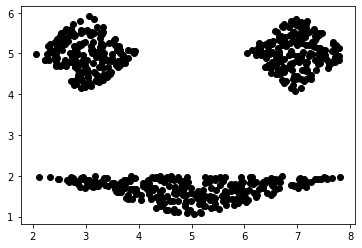

In [205]:
c = df['y'] == 1

plt.plot(df[c].x_1, df[c].x_2, 'ko')
#plt.plot(df[~c].x_1, df[~c].x_2, 'ro')
plt.show()

In [231]:
center = [5, 5]
r = 4

offset = -np.pi / 8 + .00001

points = r * np.array([[np.cos(i * np.pi / 4 + offset), np.sin(i * np.pi / 4 + offset)] for i in range(9)]) + center

In [242]:
inequalities = [[
    Inequality(get_slope_line(points[i], points[i+1]).y, '<' if i < 4 else '>') for i in range(8)
]]

df = generate_points(10000, inequalities)

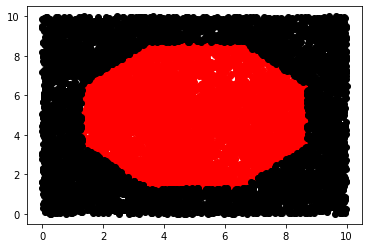

In [246]:
c = df['y'] == 1

plt.plot(df[c].x_1, df[c].x_2, 'ro')
plt.plot(df[~c].x_1, df[~c].x_2, 'ko')
plt.show()